**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/QPOw4hk84-se_w) -o data.zip

In [ ]:
!unzip data.zip >> /dev/null

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        image = image.astype(np.float32)
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        transformed = self.transform(image=sample['image'], mask=sample['mask'])
        sample['image'], sample['mask'] = transformed['image'].float(), transformed['mask'].unsqueeze(0).float()

        return sample

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_transform = A.Compose([
    A.RandomCrop(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(),
])

In [4]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

test_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

In [5]:
train_dataset = RoadDataset(X_train, y_train, train_transform)

In [6]:
X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")

In [7]:
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


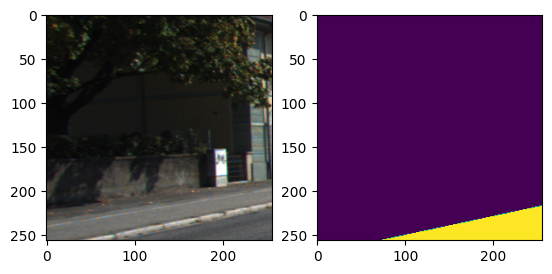

In [8]:
sample = train_dataset[110]
image = sample['image']
mask = sample['mask']

print(image.shape)
print(mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [9]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [10]:
from torch.utils.data import DataLoader

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# for i, batch in enumerate(val_loader):
#     if i > 5:
#         break
#     print(batch['image'].shape)

In [12]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        # x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        # x = self.bn2(x)
        x = self.relu2(x)

        return x

""" Encoder block:
    It consists of an ConvBlock followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the ConvBlock.
    Here the number filters decreases by half and the height and width doubles.
"""
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        # self.up = nn.Upsample(in_c)
        self.conv = ConvBlock(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [52]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = EncoderBlock(3, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)

        """ Bottleneck """
        self.b = ConvBlock(512, 1024)

        """ Decoder """
        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

In [53]:
unet_model = UNet().to(device)

In [54]:
# from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# # Step 1: Initialize model with the best available weights
# weights = FCN_ResNet50_Weights.DEFAULT
# unet_model = fcn_resnet50(weights=weights)


In [55]:
unet_model = unet_model.to(device)

In [56]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [57]:
from IPython.display import clear_output
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    val_loss, train_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_train_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            # print(Y_batch.shape, Y_pred.shape)
            loss = loss_fn(Y_batch, Y_pred)
            # print(loss)
            loss.mean().backward()
            opt.step()

            # calculate loss to show the user
            avg_train_loss += loss.mean().item() / len(data_tr)
        print('Train loss: %f' % avg_train_loss)
        train_loss.append(avg_train_loss)

        # show intermediate results
        avg_test_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in data_val:
                X_batch, Y_batch = batch['image'], batch['mask']
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                avg_test_loss += loss.mean().item() / len(data_val)
            print('Test loss: %f' % avg_test_loss)
            val_loss.append(avg_test_loss)

            # scheduler.step(avg_test_loss)
        #     # Visualize tools
            clear_output(wait=True)
            plt.figure(figsize=(18, 6))
            plt.plot(train_loss, label='train_loss')
            plt.plot(val_loss, label='val_loss')
            plt.legend()
            plt.show()

            batch = next(iter(data_val))
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_hat = torch.sigmoid(model(X_batch).detach().cpu()) > 0.5
            
            m = X_batch.shape[0]
            plt.figure(figsize=(18, 6))
            for k in range(m):
                plt.subplot(2, m, k+1)
                plt.imshow(np.rollaxis(X_batch[k].cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')
                plt.subplot(2, m, k+1+m)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_test_loss))
            plt.show()
        #     for k in range(6):
        #     plt.subplot(2, 6, k+1)
        #     plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        #     plt.title('Real')
        #     plt.axis('off')

        #     plt.subplot(2, 6, k+7)
        #     plt.imshow(Y_hat[k, 0], cmap='gray')
        #     plt.title('Output')
        #     plt.axis('off')
        # plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        # plt.show()

In [58]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred
    loss = y_pred - y_real * y_pred + torch.log(1+torch.exp(-y_pred))
    return loss

def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    your_loss = ((1 - torch.sigmoid(y_pred))**gamma)*y_real*torch.log(torch.sigmoid(y_pred) + eps) + (1-y_real)*torch.log(1-torch.sigmoid(y_pred)) 
    return -torch.mean(your_loss)

def dice_loss(y_real, y_pred):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = y_pred.contiguous().view(-1)
    tflat = y_real.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

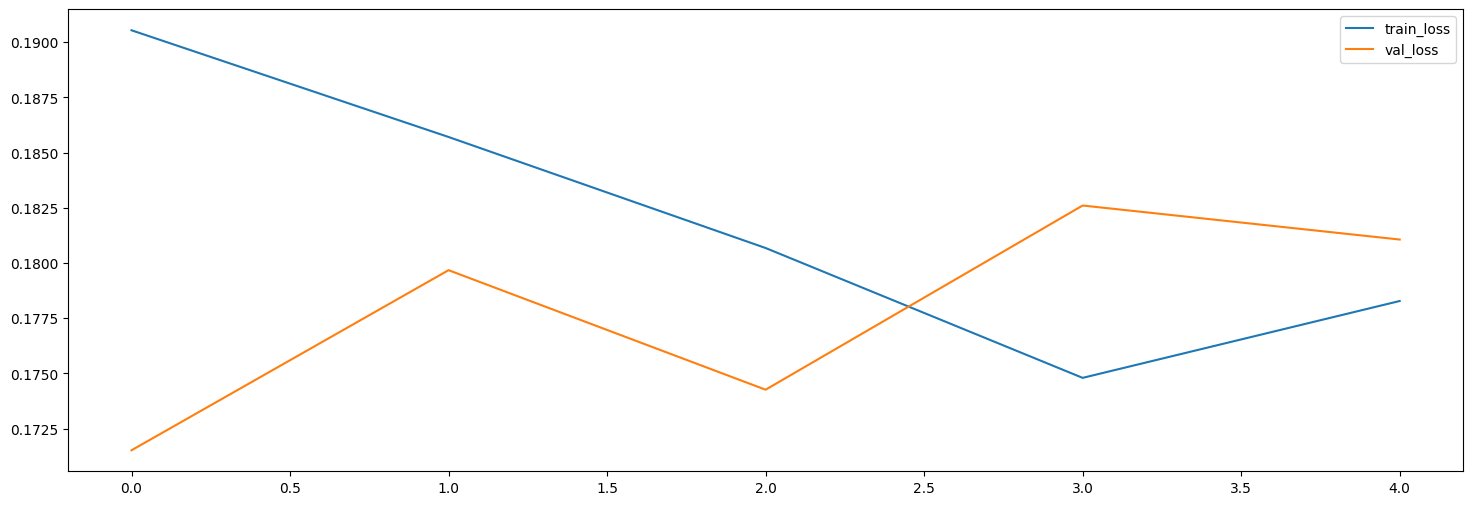

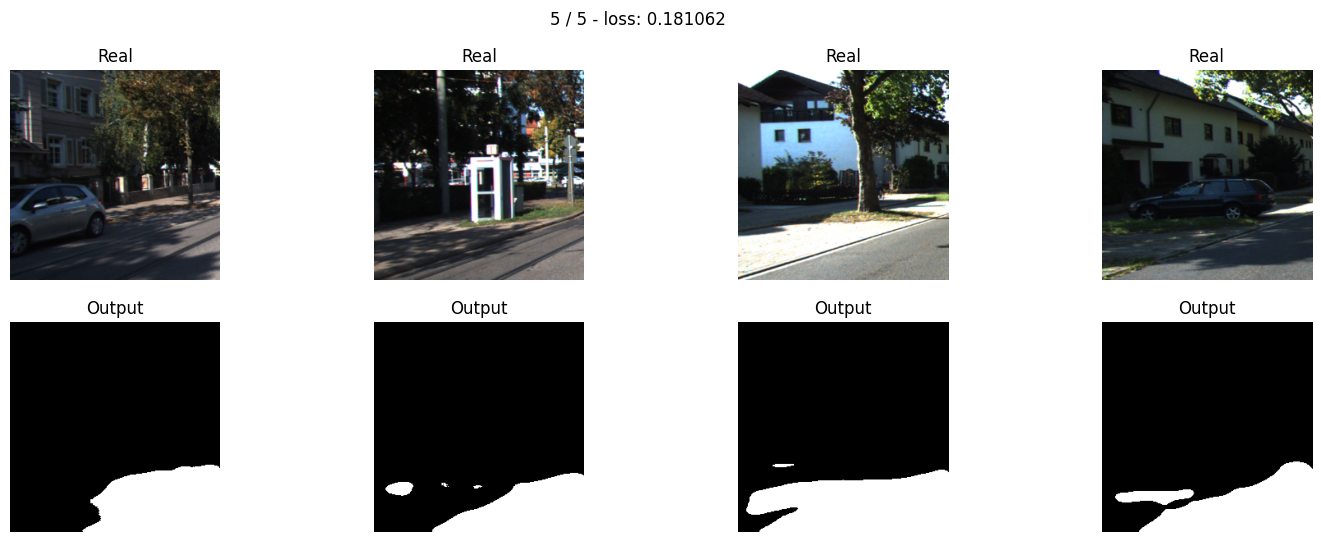

In [71]:
train(unet_model, optimizer, bce_loss, 5, train_loader, val_loader)

In [57]:
torch.save(unet_model.state_dict(), 'unet_hw2.pt')

In [68]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return intersection, union

In [69]:
def get_iou(model, val_loader):
    model.eval()
    total_intersection = 0
    total_union = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            intersection, union = calc_iou(Y_pred.detach().cpu().numpy(), Y_batch.detach().cpu().numpy())
            total_intersection += intersection
            total_union += union
            print(f'Batch {i}: {intersection / union}')
    return total_intersection / total_union

In [70]:
get_iou(unet_model, val_loader)

Batch 0: 0.7587001077608976
Batch 1: 0.8289482977821726
Batch 2: 0.7572291702926478
Batch 3: 0.46621404997642624
Batch 4: 0.4445001366991707
Batch 5: 0.48125155202383907
Batch 6: 0.5835459726120609
Batch 7: 0.8197154972314794
Batch 8: 0.9062394252544447
Batch 9: 0.9363431381291482
Batch 10: 0.6194046237334923
Batch 11: 0.1010275380189067
Batch 12: 0.009139720077220078
Batch 13: 0.265942655292924
Batch 14: 0.3828590337524818
Batch 15: 0.5566939482645319
Batch 16: 0.5481534864917122
Batch 17: 0.2350233661320245
Batch 18: 0.9072698732516459
Batch 19: 0.7760516521935266
Batch 20: 0.944872307189305
Batch 21: 0.8930234605396364
Batch 22: 0.6995563280428121
Batch 23: 0.5977931413396822
Batch 24: 0.9516308392802417
Batch 25: 0.94519936889234
Batch 26: 0.9154684137353115
Batch 27: 0.9306329520226112
Batch 28: 0.8813760483885148
Batch 29: 0.8695901793356855
Batch 30: 0.6265313386224555
Batch 31: 0.8574424552429668
Batch 32: 0.8352268645381118
Batch 33: 0.7314725697786333
Batch 34: 0.882392280500

0.6947793680034805